# 意思決定分析と予測の活用｜第3部 決定分析の活用
https://logics-of-blue.com/decision-analysis-and-forecast-book-support/

## 第3章	決定分析の事例

### Pythonによる分析の準備

In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# DataFrameの全角文字の出力をきれいにする
pd.set_option('display.unicode.east_asian_width', True)
# 本文の数値とあわせるために、小数点以下3桁で丸める
pd.set_option('display.precision', 3)

# 評価指標
from sklearn.metrics import mean_absolute_error, mean_squared_error

# グラフ描画
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# グラフの日本語表記
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Meiryo'

## 利得行列の作成

### 気温とつぼみ損失率の関係

In [2]:
# つぼみ損失率を計算する関数
def calc_bud_loss_ratio(temperature, beta_0=-2, beta_1=-1.5):
    ret = 1 / (1 + np.exp(-(beta_0 + beta_1 * temperature)))
    return(ret)

Text(0, 0.5, 'つぼみ損失率')

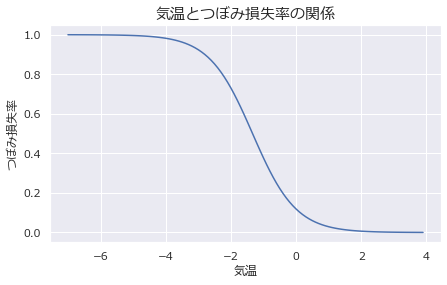

In [3]:
# つぼみ損失率のシミュレート

# 気温
temperature = np.arange(-7, 4, 0.1)

# つぼみ損失率
bud_loss_ratio = calc_bud_loss_ratio(temperature)

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(temperature, bud_loss_ratio)
ax.set_title('気温とつぼみ損失率の関係', fontsize=15)
ax.set_xlabel('気温')
ax.set_ylabel('つぼみ損失率')

### 収穫損失率を求める

In [4]:
# 収穫損失率を計算する関数
def calc_yield_loss_ratio(bud_loss_ratio, threshold=0.5):
    ret = np.where(
        bud_loss_ratio >= threshold,                        # 条件
        ((bud_loss_ratio - threshold)/(1 - threshold))**2, # 満たすとき
        0)                                                  # 満たさないとき
    return(ret)

Text(0, 0.5, '収穫損失率')

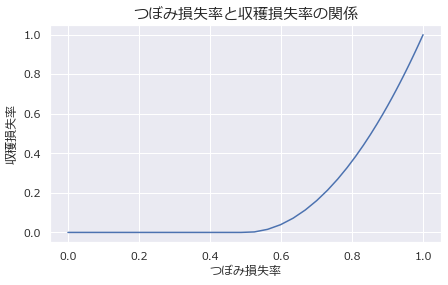

In [5]:
# 収穫損失率のシミュレート

# 収穫損失率
yield_loss_ratio = calc_yield_loss_ratio(bud_loss_ratio)

# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(bud_loss_ratio, yield_loss_ratio)
ax.set_title('つぼみ損失率と収穫損失率の関係', fontsize=15)
ax.set_xlabel('つぼみ損失率')
ax.set_ylabel('収穫損失率')

Text(0, 0.5, '収穫損失率')

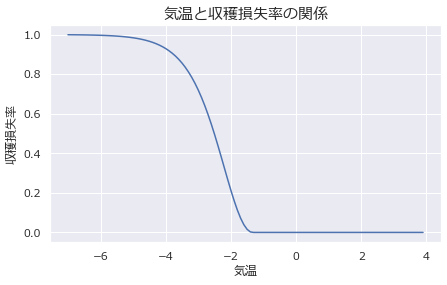

In [6]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(temperature, yield_loss_ratio)
ax.set_title('気温と収穫損失率の関係', fontsize=15)
ax.set_xlabel('気温')
ax.set_ylabel('収穫損失率')

### 気温別・対策の有無別の収益

In [7]:
# 利得行列を計算するのに使うパラメータ
temperature = np.arange(-7, 5, 1)  # 気温
T = 200                            # 1日当たりの収益
C = 20                             # 対策コスト
tmp_delta = 3                      # 対策をとることで増加できる温度

In [8]:
# つぼみ損失率
bud_loss_ratio_1 = calc_bud_loss_ratio(temperature)
bud_loss_ratio_2 = calc_bud_loss_ratio(temperature + tmp_delta)

# 収穫率
yield_ratio_1 = 1 - calc_yield_loss_ratio(bud_loss_ratio_1)
yield_ratio_2 = 1 - calc_yield_loss_ratio(bud_loss_ratio_2)

# 利得
return_1 =  yield_ratio_1 * T
return_2 =  yield_ratio_2 * T - C

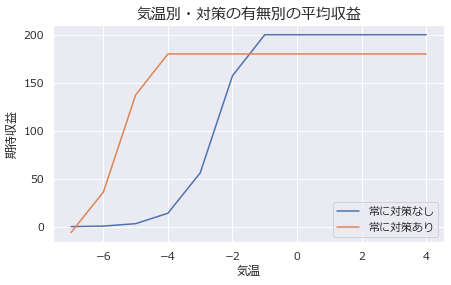

In [9]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(7, 4))

# 折れ線グラフの描画
ax.plot(temperature, return_1, label='常に対策なし')
ax.plot(temperature, return_2, label='常に対策あり')

# グラフの装飾
ax.set_title('気温別・対策の有無別の平均収益', fontsize=15)
ax.set_xlabel('気温')
ax.set_ylabel('期待収益')
ax.legend()

In [10]:
# 利得行列の作成
payoff = pd.DataFrame({
    '対策なし': return_1,
    '対策あり': return_2
})

# 行ラベルの作成
index_name = np.char.add(temperature.astype('str'), '度')
payoff.index = index_name

# 結果の確認
print(payoff)

      対策なし  対策あり
-7度     0.163    -5.870
-6度     0.728    36.083
-5度     3.243   137.290
-4度    14.130   180.000
-3度    56.083   180.000
-2度   157.290   180.000
-1度   200.000   180.000
0度    200.000   180.000
1度    200.000   180.000
2度    200.000   180.000
3度    200.000   180.000
4度    200.000   180.000


## 予測の品質の評価

### 数量予測の尺度指向アプローチに基づく評価

In [11]:
# CSVファイルの読み込み
a_f = pd.read_csv('3-3-sample-forecast-result.csv', index_col=0)
print(a_f.head(3))

   actual  forecast
0     0.4       0.3
1    -2.9      -4.6
2    -2.8      -2.4


In [12]:
# MAE
mean_absolute_error(a_f.actual, a_f.forecast)

0.5794

In [13]:
# RMSE
np.sqrt(mean_squared_error(a_f.actual, a_f.forecast))

0.7216785988236037

In [14]:
# MAPE
np.mean(np.abs((a_f.forecast - a_f.actual) / a_f.actual)) * 100

inf

### 予測値と実測値の散布図

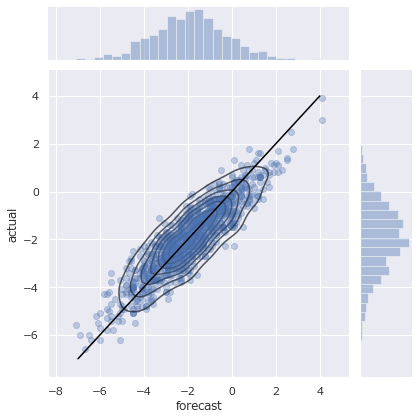

In [15]:
# 予測値と実測値の散布図+カーネル密度推定
sns.jointplot(x=a_f.forecast, y=a_f.actual, alpha=0.3) \
    .plot_joint(sns.kdeplot, alpha=0.8)
# 傾き1の直線
plt.plot([-7, 4], [-7, 4], color='black')

### 予測値と実測値の分割表

In [16]:
# ヒストグラムの階級分け
bins = np.arange(-7.5, 5, 1)
bins

array([-7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,
        3.5,  4.5])

In [17]:
# 2次元ヒストグラム
hist = np.histogram2d(a_f.actual, a_f.forecast, bins=bins)
np.set_printoptions(linewidth=70) # numpyの表示設定
print(hist[0])

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  2.   5.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   6.  12.  16.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   3.  16.  45.  21.   5.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   7.  42.  89.  54.   3.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   6.  74. 124.  55.   4.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   4.  62. 110.  61.   4.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.  36.  54.  24.   2.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   9.  19.  11.   2.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   3.   1.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]]


In [18]:
# 参考：histogram2d関数の返り値はtuple
type(hist)

tuple

In [19]:
# 参考：histogram2d関数のすべての出力
print(hist[0])
print(hist[1])
print(hist[2])

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  2.   5.   2.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   6.  12.  16.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   3.  16.  45.  21.   5.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   7.  42.  89.  54.   3.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   6.  74. 124.  55.   4.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   4.  62. 110.  61.   4.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   2.  36.  54.  24.   2.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   9.  19.  11.   2.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   3.   1.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]]
[-7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]
[-7.5 -6.5 -5.5 -4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


In [20]:
# 参考：サンプルサイズ
sum(sum(hist[0]))

1000.0

In [21]:
# 参考：列が予測で、行が実測
print('実測値<-6.5の数：', sum(a_f.actual < -6.5))
print('予測値<-6.5の数：', sum(a_f.forecast < -6.5))

実測値<-6.5の数： 1
予測値<-6.5の数： 3


In [22]:
# 相対度数にする
norm_hist = hist[0] / sum(sum(hist[0]))

# データフレームにする
joint_forecast_state = pd.DataFrame(norm_hist)
joint_forecast_state.columns = np.char.add(index_name, '予測')
joint_forecast_state.index = index_name

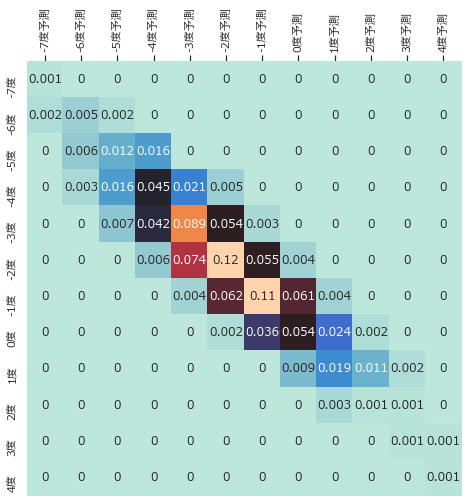

In [23]:
# 描画オブジェクトを生成
fig, ax = plt.subplots(figsize=(8, 8))

# X軸ラベルを上側に持ってくる
ax.xaxis.set_ticks_position('top')

# ヒートマップの作成
sns.heatmap(joint_forecast_state, annot=True, cbar=False, square=True, 
            vmax=0.1, vmin=0, center=0.05, ax=ax)

## 予測を用いた意思決定の実行と予測の価値評価

### 予測の価値評価の準備

In [24]:
# 最大値をとるインデックスを取得する。最大値が複数ある場合はすべて出力する。
def argmax_list(series):
    return(list(series[series == series.max()].index))

In [25]:
# 期待金額最大化に基づく意思決定を行う関数
def max_emv(probs, payoff_table):
    emv = payoff_table.mul(probs, axis=0).sum()
    max_emv = emv.max()
    a_star = argmax_list(emv)
    return(pd.Series([a_star, max_emv], index=['選択肢', '期待金額']))

In [26]:
# 周辺分布
marginal_forecast = joint_forecast_state.sum(axis=0)
marginal_state = joint_forecast_state.sum(axis=1)

In [27]:
# 予測が得られた後の条件付き分布
conditional_forecast = joint_forecast_state.div(marginal_forecast, axis=1)

### 予測を使わない場合の期待金額の最大値

In [28]:
naive_decision = max_emv(marginal_state, payoff)
naive_decision

選択肢      [対策あり]
期待金額           177
dtype: object

In [29]:
emv_naive = naive_decision['期待金額']
print(f'予測を使わないときの期待金額: {emv_naive:.3g}万円')

予測を使わないときの期待金額: 177万円


### 条件付き分布における期待利得を最大にする場合

In [30]:
info_decision = \
    conditional_forecast.apply(max_emv, axis=0, payoff_table=payoff)
print(info_decision)

            -7度予測    -6度予測    -5度予測    -4度予測    -3度予測  \
選択肢    [対策あり]  [対策あり]  [対策あり]  [対策あり]  [対策あり]   
期待金額        22.1         110         158         174         180   

            -2度予測    -1度予測     0度予測     1度予測     2度予測  \
選択肢    [対策あり]  [対策なし]  [対策なし]  [対策なし]  [対策なし]   
期待金額         180         186         199         200         200   

             3度予測     4度予測  
選択肢    [対策なし]  [対策なし]  
期待金額         200         200  


In [31]:
emv_forecast = info_decision.loc['期待金額'].mul(marginal_forecast).sum()
print(f'予測を使ったときの期待金額: {emv_forecast:.3g}万円')

予測を使ったときの期待金額: 182万円


### 同時分布を使った計算

In [32]:
# 同時分布を使って計算しても良い
emv_forecast_joint = joint_forecast_state.apply(
    max_emv, axis=0, payoff_table=payoff).loc['期待金額'].sum()
print(f'同時分布から計算された期待金額: {emv_forecast_joint:.3g}万円')

同時分布から計算された期待金額: 182万円


### 予測の価値

In [33]:
f_value = emv_forecast - emv_naive
print(f'予測の価値: {f_value:.3g}万円')

予測の価値: 5.09万円


### 予測に忠実に従う場合の意思決定

In [34]:
# 気温別最適行動
payoff.idxmax(axis=1)

-7度    対策なし
-6度    対策あり
-5度    対策あり
-4度    対策あり
-3度    対策あり
-2度    対策あり
-1度    対策なし
0度     対策なし
1度     対策なし
2度     対策なし
3度     対策なし
4度     対策なし
dtype: object

In [35]:
# 「予測に忠実に従う」という行動をとったときの利得行列
payoff_naive_f = payoff[payoff.idxmax(axis=1)]
payoff_naive_f

,対策なし,対策あり,対策あり,対策あり,対策あり,対策あり,対策なし,対策なし,対策なし,対策なし,対策なし,対策なし
-7度,0.163,-5.870,-5.870,-5.870,-5.870,-5.870,0.163,0.163,0.163,0.163,0.163,0.163
-6度,0.728,36.083,36.083,36.083,36.083,36.083,0.728,0.728,0.728,0.728,0.728,0.728
-5度,3.243,137.290,137.290,137.290,137.290,137.290,3.243,3.243,3.243,3.243,3.243,3.243
-4度,14.130,180.000,180.000,180.000,180.000,180.000,14.130,14.130,14.130,14.130,14.130,14.130
-3度,56.083,180.000,180.000,180.000,180.000,180.000,56.083,56.083,56.083,56.083,56.083,56.083
-2度,157.290,180.000,180.000,180.000,180.000,180.000,157.290,157.290,157.290,157.290,157.290,157.290
-1度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000
0度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000
1度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000
2度,200.000,180.000,180.000,180.000,180.000,180.000,200.000,200.000,200.000,200.000,200.000,200.000


In [36]:
# 「予測に忠実に従う」という行動をとったときの期待金額
weighted_payoff_naive = joint_forecast_state.values * payoff_naive_f.values
emv_naive_f = sum(sum(weighted_payoff_naive))
# 予測の価値
naive_f_value = emv_naive_f - emv_naive
print(f'予測の価値: {naive_f_value:.3g}万円')

予測の価値: 5.02万円


### 完全情報の価値

In [37]:
# 自然の状態別の最大の利得
payoff.max(axis=1)

-7度      0.163
-6度     36.083
-5度    137.290
-4度    180.000
-3度    180.000
-2度    180.000
-1度    200.000
0度     200.000
1度     200.000
2度     200.000
3度     200.000
4度     200.000
dtype: float64

In [38]:
# 自然の状態にあわせて利得を最大にする行動をとったときの期待金額
emv_perfect = payoff.max(axis=1).mul(marginal_state).sum()
# 完全情報の価値
perfect_information_value = emv_perfect - emv_naive
print(f'完全情報の価値: {perfect_information_value:.3g}万円')

完全情報の価値: 8.17万円


In [39]:
# 予測の効率性
efficiency = f_value / perfect_information_value
print(f'予測の有効性: {efficiency:.3g}')

予測の有効性: 0.623
